In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
"""
This notebook implements the Logistic Regression in the 
"Cutting the Metropolis Hastings Budget" framework. 

The target distribution is the posterior for a logistic regression
model trained on MNIST dataset for classifying digits 7 vs 9. The 
dataset consisted of 12007 datapoints. 
"""

# get input data

mat = scipy.io.loadmat('minist7vs1.mat')
TrainLabel = mat['TrainLabel']
TrainLabel = np.reshape(TrainLabel, TrainLabel.shape[1],1)
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']
print TrainLabel.shape
print TrainImg.shape
print TrainImg[0].shape
TestLabel = np.reshape(TestLabel, TestLabel.shape[1],1)

(12007,)
(12007, 784)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(784,)


In [3]:
"""
Cutting the Metropolis Hastings Budget Method
"""
def random_walk_proposer(beta_t, sigmarw):
    """
    Input: beta_t  : previous parameters, 1-D array
           sigmarw : standard deviation, 1-D array
    """
    res = (np.random.multivariate_normal(beta_t, np.diag(sigmarw))).reshape((len(beta_t),))
    return res

def ll_data(beta_t, beta_n, X, Y):
    p_x_beta_t = 1/(1 + exp(-1* Y*np.dot(beta_t,X)))
    p_x_beta_n = 1/(1 + exp(-1* Y*np.dot(beta_n,X)))
    return log(p_x_beta_n) - log(p_x_beta_t)

def eval_U0(N):
    u = np.random.random()
    return 1/N*log(u)

def make_decision(l_list, N, U0):
    n = float(len(l_list))
    l_mean = sum(l_list)/n
    l_sq = ((np.array(l_list))**2).tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean - l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_parameter(beta_t, N, sigmarw, X, Y, batchsize, epsilon ):
    U0 = eval_U0(N)
    # generate new parameter
    P = len(X[0])
    sigma = (np.matlib.repmat(sigmarw, P,1)).reshape(P,)
    beta_n = random_walk_proposer(beta_t, sigma)
    
    # make decision
    l_list = []
    for i in range(batchsize):
        mid = ll_data(beta_t, beta_n, X[i], Y[i])
        l_list.append(mid)
    
    pos = batchsize
    delta = make_decision(l_list, N, U0)
    while (delta>epsilon) and (pos < N):
        mid = ll_data(beta_t, beta_n, X[pos], Y[pos])
        l_list.append(mid)
        pos = pos + 1
        delta = make_decision(l_list, N, U0)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0:
        return (beta_n,1,pos)
    else:
        return (beta_t,0,pos)
    
def eval_cost(X,Y,beta):
    N = len(Y)
    cost = 0
    for i in range(N):
        # sigmoid = 1/(1 + exp(-1* Y[i]*np.dot(beta,X[i])))
        sigmoid = -1.0 * np.log(1 + exp(-1 * Y[i] * np.dot(beta, X[i])))
        # if sigmoid < 0.5 : 
        cost = cost + sigmoid
    return cost/float(N)
    
def train(X, Y, sigmarw, batchsize, epsilon, niter):
    N = len(Y) # number of total training data
    P = len(X[0]) # parameter dimension
    beta_t = np.ones(P)
    cost_list = []
    accept_pos = []
    for i in range(niter):
        index = np.random.permutation(N)
        X = X[index]
        Y = Y[index]
        (beta_t, mid, pos) = generate_parameter(beta_t, N, sigmarw, X,Y,batchsize,epsilon)
        # cost = eval_cost(X,Y,beta_t)
        cost = eval_cost(TestImg, TestLabel, beta_t)
        cost_list.append(cost)
        accept_pos.append(pos)
    return (cost_list, accept_pos)

X = TrainImg
Y = TrainLabel
sigmarw = 0.01
batchsize = 10
epsilon = 0.02
niter = 500
(cost_list, accept_pos) = train(X, Y, sigmarw, batchsize, epsilon, niter)

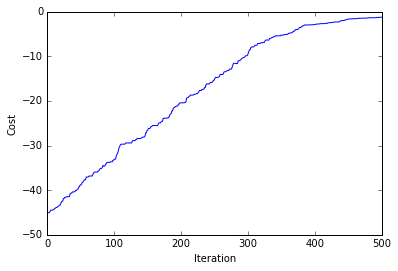

500
[248, 61, 10, 147, 22, 12, 10, 187, 80, 34, 890, 64, 101, 35, 5146, 47, 14, 87, 10, 70, 30, 15, 49, 19, 18, 10, 19, 20, 1508, 48, 33, 16, 88, 14, 10, 88, 37, 20, 30, 432, 44, 65, 22, 53, 94, 19, 10, 10, 693, 18, 374, 10, 10, 16, 17, 10, 10, 648, 10, 16, 11, 10, 12, 17, 41, 233, 315, 25, 15, 22, 11, 10, 52, 779, 119, 10, 11, 62, 13, 16, 8181, 26, 64, 10, 19, 489, 31, 18, 10, 17, 477, 2606, 16, 10, 24, 37, 27, 35, 11, 126, 17, 73, 26, 15, 13, 26, 10, 19, 20, 24, 37, 59, 22, 1214, 28, 76, 10, 15, 11, 21, 22, 12, 17, 10, 27, 10, 52, 12, 37, 12, 277, 120, 45, 50, 23, 11, 16, 13, 79, 49, 195, 37, 62, 55, 16, 12, 48, 14, 66, 21, 3078, 15, 10, 137, 39, 10, 42, 22, 12, 14, 83, 17, 10, 18, 22, 69, 10, 291, 73, 10, 21, 133, 1148, 10, 10, 452, 11, 48, 22, 71, 32, 1572, 10, 13, 10, 35, 17, 45, 15, 10, 374, 10, 19, 126, 10, 134, 39, 100, 33, 30, 64, 38, 148, 10, 10, 186, 12, 59, 10, 91, 359, 35, 18, 10, 14, 36, 27, 757, 87, 90, 373, 12, 101, 13, 13, 25, 14, 10, 16, 31, 10, 29, 16, 303, 24, 33, 2

In [4]:
plt.figure()
plt.plot(cost_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()
print len(cost_list)
print accept_pos

In [5]:
print sum(accept_pos)/float(len(accept_pos))

353.098


500
500


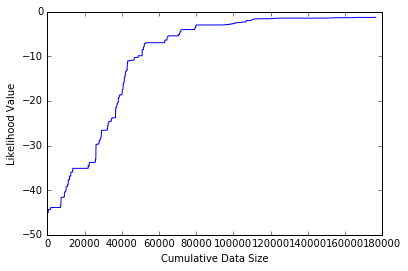

In [6]:
cumulate_datasize = [accept_pos[0]]
cumulate = accept_pos[0]
for i in range(1,len(accept_pos)):
    cumulate += accept_pos[i]
    cumulate_datasize.append(cumulate)

plt.figure()
print len(cumulate_datasize)
print len(cost_list)
plt.plot(cumulate_datasize, cost_list) 
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.show()